# Enunciado
Utilizar otro dataset y poner en práctica la generación de secuencias con las estrategias presentadas.

# Desarrollo

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [32]:
import random
import io
import pickle
import os
import platform
import unicodedata

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Datos
Como ejemplo se utilizará como corpus un dataset canciones de bandas de habla inglés.

In [33]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('libro_dataset/Sun_Tzu_El_Arte_de_la_Guerra.txt', sep='/n', header=None, names=['texto'])
df.head()

/var/folders/sp/hjjl899x4js87jvp7rfdpj2w0000gn/T/ipykernel_46647/1898976471.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('libro_dataset/Sun_Tzu_El_Arte_de_la_Guerra.txt', sep='/n', header=None, names=['texto'])


,texto
0,El Arte de la Guerra
1,Sun Tzu
2,Capítulo 1. Sobre la evaluación
3,Sun Tzu dice: la guerra es de vital importanci...
4,"dominio de la vida o de la muerte, el camino h..."


Consideraremos que cada secuencia para este dataset es un verso.

Una de las primeras decisiones que hay que tomar es el tamaño de contexto de tokens máximo que puede consumir el modelo. Este podría ser un hiperparámetro del problema.

Para elegir el tamaño de contexto máximo para este problema se puede explorar el dataset, para ello:
- se consideran las palabras como términos.
- se segmentará el texto de todos los versos del dataset y ses explorará la cantidad de términos presentes.



In [34]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 1464


#  Preprocesamiento

In [35]:
# Pasar todo a minúsculas
df['texto'] = df['texto'].str.lower()
# Eliminar puntuación
df['texto'] = df['texto'].str.replace(r'[^\w\s]', '', regex=True)
# Sacar numeros? Me parece que ayuda sacar los numeros ya estan los numeros de las 
# paginas incluidos lo cual agrega ruido
df['texto'] = df['texto'].str.replace(r'\d+', '', regex=True)
# Remover filas vacías o con solo espacios en la columna 'texto'
df = df[df['texto'].str.strip() != '']
df = df.reset_index(drop=True)

In [36]:
# Función para quitar acentos de una cadena
def quitar_acentos(texto):
    if isinstance(texto, str):
        texto = unicodedata.normalize('NFKD', texto)
        texto = texto.encode('ASCII', 'ignore').decode('utf-8')
    return texto

# Aplicar la función a la columna de texto
df['texto'] = df['texto'].apply(quitar_acentos)

### Elegir el tamaño del contexto

In [37]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding


In [38]:
# cada verso lo guardamos en una lista
#text = list(df.loc[:,0])
text = list(df['texto'])
text

['el arte de la guerra',
 'sun tzu',
 'capitulo  sobre la evaluacion',
 'sun tzu dice la guerra es de vital importancia para el estado es el',
 'dominio de la vida o de la muerte el camino hacia la supervivencia o la',
 'perdida del imperio es forzoso manejarla bien no reflexionar seriamente',
 'sobre todo lo que le concierne es dar prueba de una culpable indiferencia',
 'en lo que respecta a la conservacion o perdida de lo que nos es mas',
 'querido y ello no debe ocurrir entre nosotros',
 'hay que valorarla en terminos de cinco factores fundamentales y hacer',
 'comparaciones entre diversas condiciones de los bandos rivales con',
 'vistas a determinar el resultado de la guerra el primero de estos factores',
 'es la doctrina el segundo el tiempo el tercero el terreno el cuarto el',
 'mando y el quinto la disciplina',
 'la doctrina significa aquello que hace que el pueblo este en armonia con',
 'su gobernante de modo que le siga donde sea sin temer por sus vidas ni',
 'a correr cualqui

In [39]:
# segmentamos el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]

In [40]:
text[0]

'el arte de la guerra'

In [41]:
segmented_sentences[0]

['el', 'arte', 'de', 'la', 'guerra']

In [42]:
# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

(array([ 88.,  20.,  49.,  31.,  34.,  49.,   0.,  39.,  52.,  81., 140.,
        206., 242.,   0., 221., 109.,  36.,  14.,   1.,   1.]),
 array([ 1.  ,  1.85,  2.7 ,  3.55,  4.4 ,  5.25,  6.1 ,  6.95,  7.8 ,
         8.65,  9.5 , 10.35, 11.2 , 12.05, 12.9 , 13.75, 14.6 , 15.45,
        16.3 , 17.15, 18.  ]),
 <BarContainer object of 20 artists>)

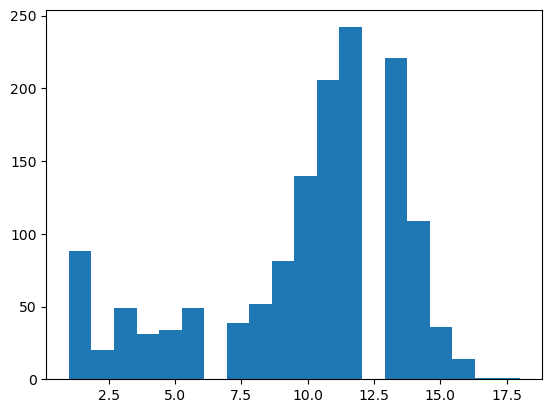

In [43]:
# podemos ver su distribución
plt.hist(length_sentences,bins=20)

In [44]:
# a partir de la distribución de longitudes de secuencias elegimos algún criterio
# para determinar el máximo tamaño de contexto. En este caso es un percentil, pero
# otros criterios también pueden ser válidos con la justificación adecuada.
# También puede ser una selección "a mano"

# el -1 es porque el último token será el target
max_context_size = int(np.percentile(length_sentences, 95)-1)

# max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
# max_context_size = int(np.ceil(np.median(length_sentences))) # criterio de mediana
print(f'max_context_size: {max_context_size}')

max_context_size: 13


###  Tokenizar

In [45]:
# instanciamos el tokenizador
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [46]:
tokenized_sentences[0]

[5, 179, 1, 3, 89]

In [47]:
segmented_sentences[0]

['el', 'arte', 'de', 'la', 'guerra']

### Organizando y estructurando el dataset

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [48]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)

\Vamos a splitear las oraciones que tienen tamaño mayor al contexto máximo, para generarnos más secuencias de entrenamiento. Este paso puede obviarse si el tamaño de contexto máximo es muy grande.

Por ejemplo, si tenemos el texto *La bella y graciosa moza marchóse a lavar la ropa* y nuestro contexto es de 5 palabras, tendremos:

- *La bella y graciosa moza*
- *bella y graciosa moza marchóse*
- *y graciosa moza marchóse a*
- *graciosa moza marchóse a lavar*
- *moza marchóse a lavar la*
- *marchóse a lavar la ropa*

In [49]:
tok_sent = [] # lista que contendrá las subsecuencias de tamaño máximo

# para cada secuencia de entrenamiento
for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)


In [50]:
len(tok_sent)

1184

Ahora aumentamos los datos aprovechando que de una secuencia grande se pueden generar varias más pequeñas:

- *La hermosa casa en el prado*
- *La hermosa*
- *La hermosa casa*
- *La hermosa casa en*
- *La hermosa casa en el*
- *La hermosa casa en el prado*

In [51]:
tok_sent_augm = []

for sent in tok_sent:
  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))


In [52]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [53]:
train_seqs.shape

(10675, 14)

In [54]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,1:]

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

In [55]:
y.shape

(10675, 13)

In [56]:
# Palabras del vocabulario
tok.index_word

{1: 'de',
 2: 'que',
 3: 'la',
 4: 'y',
 5: 'el',
 6: 'los',
 7: 'en',
 8: 'a',
 9: 'se',
 10: 'no',
 11: 'es',
 12: 'las',
 13: 'un',
 14: 'si',
 15: 'cuando',
 16: 'para',
 17: 'una',
 18: 'por',
 19: 'lo',
 20: 'del',
 21: 'enemigo',
 22: 'sus',
 23: 'terreno',
 24: 'son',
 25: 'con',
 26: 'como',
 27: 'al',
 28: 'su',
 29: 'esta',
 30: 'tropas',
 31: 'soldados',
 32: 'tus',
 33: 'ser',
 34: 'puede',
 35: 'ejercito',
 36: 'estan',
 37: 'victoria',
 38: 'sin',
 39: 'tu',
 40: 'asi',
 41: 'esto',
 42: 'fuerza',
 43: 'batalla',
 44: 'pero',
 45: 'adversarios',
 46: 'manera',
 47: 'puedes',
 48: 'mas',
 49: 'o',
 50: 'este',
 51: 'te',
 52: 'ni',
 53: 'general',
 54: 'pueden',
 55: 'sobre',
 56: 'estas',
 57: 'hacer',
 58: 'fuerzas',
 59: 'solo',
 60: 'significa',
 61: 'militares',
 62: 'pues',
 63: 'enemigos',
 64: 'tanto',
 65: 'lugar',
 66: 'adversario',
 67: 'donde',
 68: 'atacar',
 69: 'ti',
 70: 'todo',
 71: 'debe',
 72: 'entre',
 73: 'militar',
 74: 'territorio',
 75: 'ellos',
 7

In [57]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

2780

In [58]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'de': 1, 'que': 2, 'la': 3, 'y': 4, 'el': 5, 'los': 6, 'en': 7, 'a': 8, 'se': 9, 'no': 10, 'es': 11, 'las': 12, 'un': 13, 'si': 14, 'cuando': 15, 'para': 16, 'una': 17, 'por': 18, 'lo': 19, 'del': 20, 'enemigo': 21, 'sus': 22, 'terreno': 23, 'son': 24, 'con': 25, 'como': 26, 'al': 27, 'su': 28, 'esta': 29, 'tropas': 30, 'soldados': 31, 'tus': 32, 'ser': 33, 'puede': 34, 'ejercito': 35, 'estan': 36, 'victoria': 37, 'sin': 38, 'tu': 39, 'asi': 40, 'esto': 41, 'fuerza': 42, 'batalla': 43, 'pero': 44, 'adversarios': 45, 'manera': 46, 'puedes': 47, 'mas': 48, 'o': 49, 'este': 50, 'te': 51, 'ni': 52, 'general': 53, 'pueden': 54, 'sobre': 55, 'estas': 56, 'hacer': 57, 'fuerzas': 58, 'solo': 59, 'significa': 60, 'militares': 61, 'pues': 62, 'enemigos': 63, 'tanto': 64, 'lugar': 65, 'adversario': 66, 'donde': 67, 'atacar': 68, 'ti': 69, 'todo': 70, 'debe': 71, 'entre': 72, 'militar': 73, 'territorio': 74, 'ellos': 75, 'tienen': 76, 'le': 77, 'sea': 78, 'espias': 79, 'planes': 80, 'tiene': 81, 

In [59]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'guerra': 18, 'el': 307, 'arte': 9, 'la': 347, 'de': 477, 'tzu': 2, 'sun': 2, 'capitulo': 13, 'evaluacion': 2, 'sobre': 31, 'importancia': 1, 'estado': 1, 'es': 206, 'para': 148, 'dice': 13, 'vital': 1, 'o': 37, 'muerte': 10, 'camino': 11, 'hacia': 13, 'supervivencia': 2, 'vida': 6, 'dominio': 2, 'perdida': 2, 'manejarla': 1, 'seriamente': 1, 'imperio': 1, 'no': 232, 'forzoso': 1, 'reflexionar': 1, 'bien': 15, 'del': 92, 'concierne': 2, 'culpable': 1, 'indiferencia': 1, 'una': 120, 'le': 21, 'dar': 3, 'lo': 89, 'que': 379, 'prueba': 2, 'todo': 22, 'mas': 36, 'a': 275, 'nos': 1, 'en': 282, 'conservacion': 1, 'respecta': 1, 'debe': 22, 'ello': 6, 'entre': 22, 'nosotros': 1, 'ocurrir': 1, 'y': 382, 'querido': 1, 'valorarla': 1, 'factores': 8, 'fundamentales': 2, 'hay': 16, 'hacer': 27, 'terminos': 1, 'cinco': 11, 'comparaciones': 4, 'bandos': 3, 'rivales': 3, 'con': 77, 'los': 300, 'condiciones': 7, 'diversas': 2, 'primero': 19, 'determinar': 4, 'resultado': 5,


## Trabajo con el modelo LSTM

### Definición del modelo

In [61]:
from tensorflow.keras.layers import LeakyReLU

# Modelo de prueba de implementacion  
model = Sequential()
model.add(Embedding(input_dim=vocab_size+1, output_dim=100, input_shape=(None,)))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.5))
model.add(Dense(512))  # Capa intermedia
model.add(LeakyReLU(alpha=0.01))  # LeakyReLU con alpha=0.01
model.add(Dense(vocab_size+1, activation='softmax'))  # Capa de salida

model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')
#model.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam')
model.summary()

/opt/anaconda3/envs/ia_ceia_18co/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/envs/ia_ceia_18co/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, None, 100)      │       278,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, None, 256)      │       365,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, None, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, None, 256)      │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, None, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, None, 512)      │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, None, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, None, 2781)     │     1,426,653 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,727,217 (10.40 MB)

 Trainable params: 2,727,217 (10.40 MB)

 Non-trainable params: 0 (0.00 B)

### Defino el Callback para medir la Perplejidad

In [62]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, nombre_mejor_modelo, patience=20):
        # El callback lo inicializamos con secuencias de validación sobre las cuales
        # mediremos la perplejidad y la paciencia para detener el entrenamiento.
        self.val_data = val_data

        self.target = []
        self.padded = []

        count = 0
        self.info = []
        self.history_ppl = []
        self.min_score = np.inf
        self.patience_counter = 0
        self.patience = patience
        self.nombre_mejor_modelo = nombre_mejor_modelo

        # nos movemos en todas las secuencias de los datos de validación
        for seq in self.val_data:
            len_seq = len(seq)
   	        # armamos todas las subsecuencias
            subseq = [seq[:i] for i in range(len_seq)]
            self.target.extend([seq[i] for i in range(len_seq)])
            
            if len(subseq)!=0:
                self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))
                self.info.append((count,count+len_seq))
                count += len_seq

        self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):
        #print(f'\nEpoch {epoch+1} ended. Calculating perplexity...')
        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded)
        #print(f'Predictions shape: {predictions.shape}')
        # para cada secuencia de validación
        for start,end in self.info:
            #print(f'Processing sequence from {start} to {end}')
            # en `probs` iremos guardando las probabilidades de los términos target
            probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]
          
            # calculamos la perplejidad por medio de logaritmos
            scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {round(current_score, 2)} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
            self.min_score = current_score
            self.model.save(nombre_mejor_modelo)
            print("Saved new model!")
            self.patience_counter = 0
        else:
            self.patience_counter += 1
            if self.patience_counter == self.patience:
            	print("Stopping training...")
            	self.model.stop_training = True


### Entrenamiento

In [63]:
# Prueba con menos datos porque se me muere el kernel
#X_small = X[:10000]
#y_small = y[:10000]
#history_ppl = []
#hist = model.fit(X_small, y_small, epochs=5, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=64)
#hist = model.fit(X_small, y_small, epochs=5, batch_size=64)

In [64]:
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
nombre_mejor_modelo = 'best_LSTM_model.keras'
hist = model.fit(X, y, epochs=100, callbacks=[PplCallback(tokenized_sentences_val,history_ppl,nombre_mejor_modelo)], batch_size=128)
print('\nPerplejidad del mejor modelo: ', np.exp(hist.history['loss'][-1]))

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step

 mean perplexity: 3105.66 

Saved new model!
84/84 ━━━━━━━━━━━━━━━━━━━━ 27s 309ms/step - loss: 5.2223
Epoch 2/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step

 mean perplexity: 5921.37 

84/84 ━━━━━━━━━━━━━━━━━━━━ 25s 292ms/step - loss: 3.3541
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step

 mean perplexity: 3640.19 

84/84 ━━━━━━━━━━━━━━━━━━━━ 26s 312ms/step - loss: 3.2926
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step

 mean perplexity: 14628.15 

84/84 ━━━━━━━━━━━━━━━━━━━━ 22s 259ms/step - loss: 3.2578
Epoch 5/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step

 mean perplexity: 13066.93 

84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 237ms/step - loss: 3.2494
Epoch 6/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step

 mean perplexity: 15401.25 

84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 236ms/step - loss: 3.1881
Epoch 7/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step

 mean perplexity: 4438.19 

84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 236ms/step - loss: 3.1653
Epoch 8/100
91

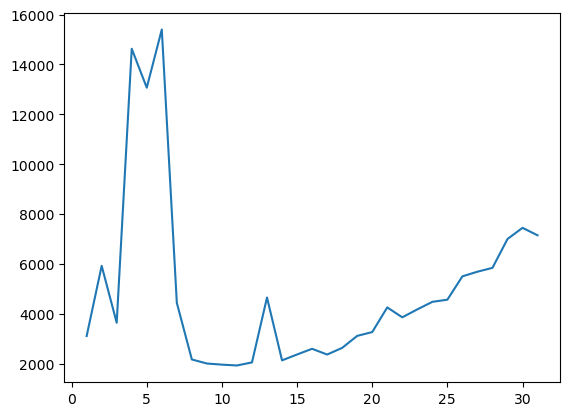

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Podemos graficar la evolución de la perplejidad con las épocas.
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [67]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('best_LSTM_model.keras')


### Predicción de próxima palabra

In [68]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

In [69]:
import gradio as gr

def model_response(human_text, model):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario la palabra
    # que corresponde al indice (y_hat) predicho por el modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word


In [70]:
iface = gr.Interface(
    #fn=model_response,
	fn=lambda x: model_response(x, model=model),
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Keyboard interruption in main thread... closing server.


### Generación de secuencias

In [71]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	  # generate a fixed number of words
    for _ in range(n_words):
		  # Tokenizamos
      encoded = tokenizer.texts_to_sequences([output_text])[0]

		  # Si tienen distinto largo
      encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		  # Predicción softmax
      y_hat = np.argmax(model.predict(encoded)[0,-1,:])

      # Vamos concatenando las predicciones
      out_word = ''

      # Debemos buscar en el vocabulario la palabra
      # que corresopnde al indice (y_hat) predicho por le modelo
      for word, index in tokenizer.word_index.items():
        if index == y_hat:
          out_word = word
          break

		  # Agrego las palabras a la frase predicha
      output_text += ' ' + out_word

    return output_text

In [73]:
input_text = 'la guerra es'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


'la guerra es que de que de el'

###  Beam search y muestreo aleatorio

In [74]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [75]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat], num_beams, vocab_size, history_probs, history_tokens, temp, mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

### Corremos Search Beam

In [76]:
# predicción con beam search.
salidas = beam_search(model, num_beams=5, num_words=4, input="la guerra es", temp=1, mode='sto')

# veamos las salidas
for i in range(len(salidas)):
    print(f"Salida {i}: {decode(salidas[i])[0]}")

Salida 0: la guerra es los no y esfuerzo
Salida 1: la guerra es los no y que
Salida 2: la guerra es los no y dirigir
Salida 3: la guerra es los soldados los hables
Salida 4: la guerra es los no y prendido


In [77]:
# Cambio la temperatura.
salidas = beam_search(model, num_beams=5, num_words=4, input="la guerra es", temp=5, mode='sto')

# veamos las salidas
for i in range(len(salidas)):
    print(f"Salida {i}: {decode(salidas[i])[0]}")

Salida 0: la guerra es ventaja operaciones gran los
Salida 1: la guerra es ventaja operaciones los hace
Salida 2: la guerra es ventaja recompensas basa antemano
Salida 3: la guerra es ventaja operaciones gran incrementar
Salida 4: la guerra es ventaja operaciones gran cabo


In [78]:
# Pruebo con deterministico
salidas = beam_search(model, num_beams=5, num_words=4, input="la guerra es", mode='det')

# veamos las salidas
for i in range(len(salidas)):
    print(f"Salida {i}: {decode(salidas[i])[0]}")

Salida 0: la guerra es la que de de
Salida 1: la guerra es la que de que
Salida 2: la guerra es de de que de
Salida 3: la guerra es de de de que
Salida 4: la guerra es la que de la


### Greedy Search

In [79]:
# predicción con beam search.
salidas = beam_search(model, num_beams=1, num_words=4, input="la guerra es", temp=1, mode='sto')

# veamos las salidas
for i in range(len(salidas)):
    print(f"Salida {i}: {decode(salidas[i])[0]}")

Salida 0: la guerra es los seran cuando ser


In [80]:
# Cambio la temperatura.
salidas = beam_search(model, num_beams=1, num_words=4, input="la guerra es", temp=5, mode='sto')

# veamos las salidas
for i in range(len(salidas)):
    print(f"Salida {i}: {decode(salidas[i])[0]}")

Salida 0: la guerra es atemorizados ganan puedan inmovilizar


In [81]:
salidas = beam_search(model, num_beams=1, num_words=4, input="la guerra es", mode='det')

# veamos las salidas
for i in range(len(salidas)):
    print(f"Salida {i}: {decode(salidas[i])[0]}")

Salida 0: la guerra es que de que de


# Implemento Modelo GRU

### Definición del modelo

In [82]:
from tensorflow.keras.layers import GRU, LeakyReLU

# Modelo con GRU en vez de LSTM
model_gru = Sequential()
model_gru.add(Embedding(input_dim=vocab_size+1, output_dim=100, input_shape=(None,)))
model_gru.add(GRU(256, return_sequences=True))
model_gru.add(Dropout(0.5))
model_gru.add(GRU(256, return_sequences=True))
model_gru.add(Dropout(0.5))
model_gru.add(Dense(512))  # Capa intermedia
model_gru.add(LeakyReLU(alpha=0.01))  # LeakyReLU con alpha=0.01
model_gru.add(Dense(vocab_size+1, activation='softmax'))  # Capa de salida

model_gru.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')
model_gru.summary()

/opt/anaconda3/envs/ia_ceia_18co/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/envs/ia_ceia_18co/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, None, 100)      │       278,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, None, 256)      │       274,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, None, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, None, 256)      │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, None, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, None, 512)      │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, None, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, None, 2781)     │     1,426,653 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,506,033 (9.56 MB)

 Trainable params: 2,506,033 (9.56 MB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento

In [85]:
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
nombre_mejor_modelo = 'best_GRU_model.keras'
hist = model.fit(X, y, epochs=100, callbacks=[PplCallback(tokenized_sentences_val,history_ppl,nombre_mejor_modelo)], batch_size=256)
print('\nPerplejidad del mejor modelo: ', np.exp(hist.history['loss'][-1]))

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step

 mean perplexity: 2898.08 

Saved new model!
42/42 ━━━━━━━━━━━━━━━━━━━━ 24s 563ms/step - loss: 2.9833
Epoch 2/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step

 mean perplexity: 2354.95 

Saved new model!
42/42 ━━━━━━━━━━━━━━━━━━━━ 18s 434ms/step - loss: 2.9390
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step

 mean perplexity: 2674.42 

42/42 ━━━━━━━━━━━━━━━━━━━━ 19s 455ms/step - loss: 2.9136
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step

 mean perplexity: 2737.67 

42/42 ━━━━━━━━━━━━━━━━━━━━ 23s 554ms/step - loss: 2.8483
Epoch 5/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step

 mean perplexity: 3482.22 

42/42 ━━━━━━━━━━━━━━━━━━━━ 18s 418ms/step - loss: 2.7997
Epoch 6/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step

 mean perplexity: 3806.84 

42/42 ━━━━━━━━━━━━━━━━━━━━ 17s 404ms/step - loss: 2.7625
Epoch 7/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step

 mean perplexity: 4009.4 

42/42 ━━━━━━━━━━━━━━━━━━━━ 17s 416ms/step - loss: 2.7215
E

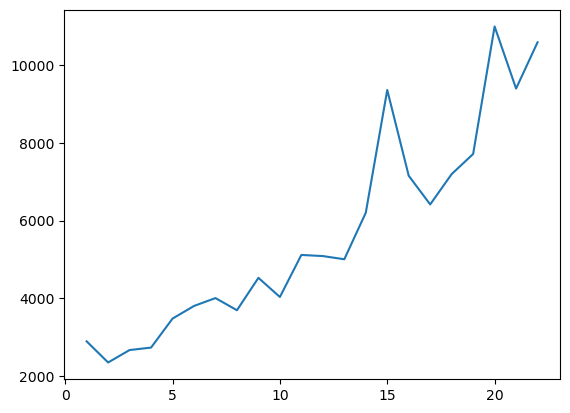

In [87]:
# Podemos graficar la evolución de la perplejidad con las épocas.
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [86]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model_gru = keras.models.load_model('best_GRU_model.keras')


### Predicción de próxima palabra

In [88]:
from functools import partial

iface = gr.Interface(
    fn=partial(model_response, model=model_gru),
    inputs=["textbox"],
    outputs="text"
)
iface.launch(debug=True)

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Keyboard interruption in main thread... closing server.


### Generación de secuencias

In [89]:
input_text = 'guerra es de'

generate_seq(model_gru, tok, input_text, max_length=max_context_size, n_words=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


'guerra es de la que de la sutil'

###  Beam search y muestreo aleatorio

In [90]:
# predicción con beam search.
salidas = beam_search(model_gru, num_beams=5, num_words=4, input="la guerra es", temp=1, mode='sto')

# veamos las salidas
for i in range(len(salidas)):
    print(f"Salida {i}: {decode(salidas[i])[0]}")

Salida 0: la guerra es un y el los
Salida 1: la guerra es un y el defensa
Salida 2: la guerra es un y el el
Salida 3: la guerra es un y el cobardia
Salida 4: la guerra es un y el botin


In [91]:
# Cambio la temperatura.
salidas = beam_search(model_gru, num_beams=5, num_words=4, input="la guerra es", temp=5, mode='sto')

# veamos las salidas
for i in range(len(salidas)):
    print(f"Salida {i}: {decode(salidas[i])[0]}")

Salida 0: la guerra es espias unos primero armonia
Salida 1: la guerra es cierran terraplenes reservado amable
Salida 2: la guerra es espias unos acercarte certera
Salida 3: la guerra es espias unos manteniendolos favorable
Salida 4: la guerra es espias unos bosque estuviera


In [92]:
# Pruebo con deterministico
salidas = beam_search(model_gru, num_beams=5, num_words=4, input="la guerra es", mode='det')

# veamos las salidas
for i in range(len(salidas)):
    print(f"Salida {i}: {decode(salidas[i])[0]}")

Salida 0: la guerra es la que de la
Salida 1: la guerra es la que es la
Salida 2: la guerra es el que de la
Salida 3: la guerra es la que de el
Salida 4: la guerra es la que es el


### Greedy Search

In [93]:
# predicción con beam search.
salidas = beam_search(model_gru, num_beams=1, num_words=4, input="la guerra es", temp=1, mode='sto')

# veamos las salidas
for i in range(len(salidas)):
    print(f"Salida {i}: {decode(salidas[i])[0]}")

Salida 0: la guerra es tal lo victoria conoce


In [94]:
# Cambio la temperatura.
salidas = beam_search(model_gru, num_beams=1, num_words=4, input="la guerra es", temp=5, mode='sto')

# veamos las salidas
for i in range(len(salidas)):
    print(f"Salida {i}: {decode(salidas[i])[0]}")

Salida 0: la guerra es valentia agitan lograr seguira


In [95]:
salidas = beam_search(model_gru, num_beams=1, num_words=4, input="la guerra es", mode='det')

# veamos las salidas
for i in range(len(salidas)):
    print(f"Salida {i}: {decode(salidas[i])[0]}")

Salida 0: la guerra es la que de la
